# Analyze Participants' Answers in Pilot 2 Study

In [4]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import Lasso
from ast import literal_eval
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from utils import *
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from key import *

In [5]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password=ssh_password,
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        query = "SELECT * FROM pilot_2 where submit_time>='2024-03-01';"
        df = pd.read_sql(query, connection)
        print(f"Data read finished, length {len(df)}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

df["pilot_2_answers"] = df["pilot_2_answers"].map(literal_eval)
df['submit_time'] = pd.to_datetime(df['submit_time'])
df = df.loc[df["participantId"] != "testId"]
df.head()

2024-03-17 13:22:26,498| ERROR   | Password is required for key /Users/guodawei/.ssh/id_rsa


Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length 601


,participantId,assignmentId,projectId,attention_passed,total_time,pilot_2_answers,ideology_label,bot_detected,submit_time,identity_choices,ideologies,reason
0,005AEEC96BCB4B3F8D6CC2DD490164DA,25fc67be-ea8d-4f0e-bcc9-4a3a96c415ac,464ae45d-fe95-4a79-a013-b4270d3e1513,1,331.181,"[{'type': 'issue', 'index': 8, 'answer': '0'},...",1.1,NaN,2024-03-09 03:49:26,None,None,None
1,00733809B26D472B84E607A9F56CA0B3,afa9cd74-4db1-4980-bb59-63284caad379,464ae45d-fe95-4a79-a013-b4270d3e1513,1,153.542,"[{'type': 'issue', 'index': 13, 'answer': '0'}...",-0.5,NaN,2024-03-09 03:34:07,None,None,None
2,009FBF921182482EB3B2C7C66D5DF395,758d7145-78b7-4f19-9552-d79fea8095d0,464ae45d-fe95-4a79-a013-b4270d3e1513,1,245.916,"[{'type': 'design', 'index': 9, 'answer': '0'}...",1.5,NaN,2024-03-07 01:36:00,None,None,None
3,00D808BCA2364DC0A9D86AAFCCF3B83E,fa8f8922-8a84-4980-bcb0-cbed2152156f,464ae45d-fe95-4a79-a013-b4270d3e1513,1,236.468,"[{'type': 'fact', 'index': 9, 'answer': '0'}, ...",1.2,NaN,2024-03-07 01:26:33,None,None,None
4,0163260E3DF74A1E8CA46ADD5D792370,9eecd9d7-56f6-4d31-a994-8b3b77a5be18,464ae45d-fe95-4a79-a013-b4270d3e1513,1,317.364,"[{'type': 'issue', 'index': 9, 'answer': '1'},...",0.0,NaN,2024-03-09 03:40:10,None,None,None


In [44]:
ids_attention_failed = df.loc[df['attention_passed'] == 0]["participantId"].tolist()
print(f"Participants who failed attention check: {ids_attention_failed}")
df = df.loc[df["attention_passed"] == 1]
df = df.loc[:, ["participantId", "pilot_2_answers", "ideology_label", "bot_detected"]].set_index("participantId")

def IdeologyToNumber(ideology):
    if ideology == "Moderate":
        return 0
    elif ideology == "Somewhat Conservative":
        return 1
    elif ideology == "Conservative":
        return 2
    elif ideology == "Somewhat Liberal": 
        return -1
    elif ideology == "Liberal":
        return -2

# connect_data_csv = glob.glob('data/connect_raw_data/pilot-2-2*.csv')[0]
# df_connect = pd.read_csv(connect_data_csv).set_index("ParticipantId")
# df["connect_ideology"] = df_connect["Political Ideology"].map(IdeologyToNumber)
# print("rmse of ideology:", np.sqrt(np.mean((df["ideology_label"] - df["connect_ideology"])**2)))
df["ideology"] = df["ideology_label"]
df.drop(["ideology_label"], axis=1, inplace=True)
df["bot_detected"] = df["bot_detected"].fillna(0)
# df.drop(["connect_ideology", "ideology_label"], axis=1, inplace=True)
df.head()

Participants who failed attention check: ['01A4A3D8DB3E44BAA3F9DE88CB8BE7F8', '08C87BD7110A4042A5CEE06F8D11A251', '0FB4B87F0F00489588CE1CCF77F0AFDC', '1504F19B761F4CB6BA5FC67174D5645C', '25A035009B3E4DD7910736BDBE4E0C7E', '39A478274DFD4DF6A045ADCCFF2230C1', '3C07AD5EA91D453AAFFA3FD5EA7F29A4', '496FE9F3667A45D1913AC4296F19246C', '4C9DBC8E43C84381975E98FBA016EF3E', '763C34E3F4AA4ECB88CEF7B708B9A6CC', '78461A9831BC41D1863B2A949F079D40', '7D11131668FB4BC78AD2B4FFA73D63C5', '8ED6F7996DDC4D52B102F96AE4670CAA', 'A92840FC7681433097E1210306788587', 'C66DB4EC171D45879828EA04A8C1852A', 'C79DE1EF9E184A6D9B6E49A4FD9E4A75', 'D795E04D0C624D87858066E662CCC4A4', 'DF7CEA53860C4C58A65369285B64E923', 'F74B6753C85D4808836AE20D79B4B5FE', 'FDB9DD9AACCE49AE91F4FC35298E2966']


,pilot_2_answers,bot_detected,ideology
participantId,,,
005AEEC96BCB4B3F8D6CC2DD490164DA,"[{'type': 'issue', 'index': 8, 'answer': '0'},...",0.0,1.1
00733809B26D472B84E607A9F56CA0B3,"[{'type': 'issue', 'index': 13, 'answer': '0'}...",0.0,-0.5
009FBF921182482EB3B2C7C66D5DF395,"[{'type': 'design', 'index': 9, 'answer': '0'}...",0.0,1.5
00D808BCA2364DC0A9D86AAFCCF3B83E,"[{'type': 'fact', 'index': 9, 'answer': '0'}, ...",0.0,1.2
0163260E3DF74A1E8CA46ADD5D792370,"[{'type': 'issue', 'index': 9, 'answer': '1'},...",0.0,0.0


In [45]:
import os
from pathlib import Path
import re
import json

folder_path = Path(os.getcwd())
pilot_2_statements_js = folder_path.parent / "app"/ "static" / "data" / "phase_2_statements.js"
with open(pilot_2_statements_js) as js:
    js_content = js.read()
    json_content = js_content.replace("\n", "").replace("/'", "'")
    json_content = json_content.lstrip("const phase_2_statements = ")
phase_2_statements = json.loads(json_content)

## 1. The Answer Patter for Each Question

In [46]:
df_exploded = df.explode(["pilot_2_answers"])
df_each = df_exploded["pilot_2_answers"].apply(pd.Series)
df_each = pd.concat([df_each, df_exploded], axis=1)
df_each = df_each.reset_index()
df_each.drop(["pilot_2_answers", "participantId"], axis=1, inplace=True)
print(df_each.groupby(["type", "index"]).size())
df_each = df_each.set_index(["bot_detected", "type", "index"])
df_each = df_each.astype({"answer": int})

type        index
design      0        271
            1        267
            2        246
            3        255
            4        260
            5        257
            6        257
            7        267
            8        257
            9        259
            10       250
            11       265
            12       270
fact        0        272
            1        252
            2        243
            3        280
            4        241
            5        256
            6        281
            7        269
            8        243
            9        286
            10       266
            11       280
            12       250
            13       271
issue       0        254
            1        250
            2        240
            3        280
            4        265
            5        247
            6        259
            7        256
            8        251
            9        269
            10       248
            11       268
       

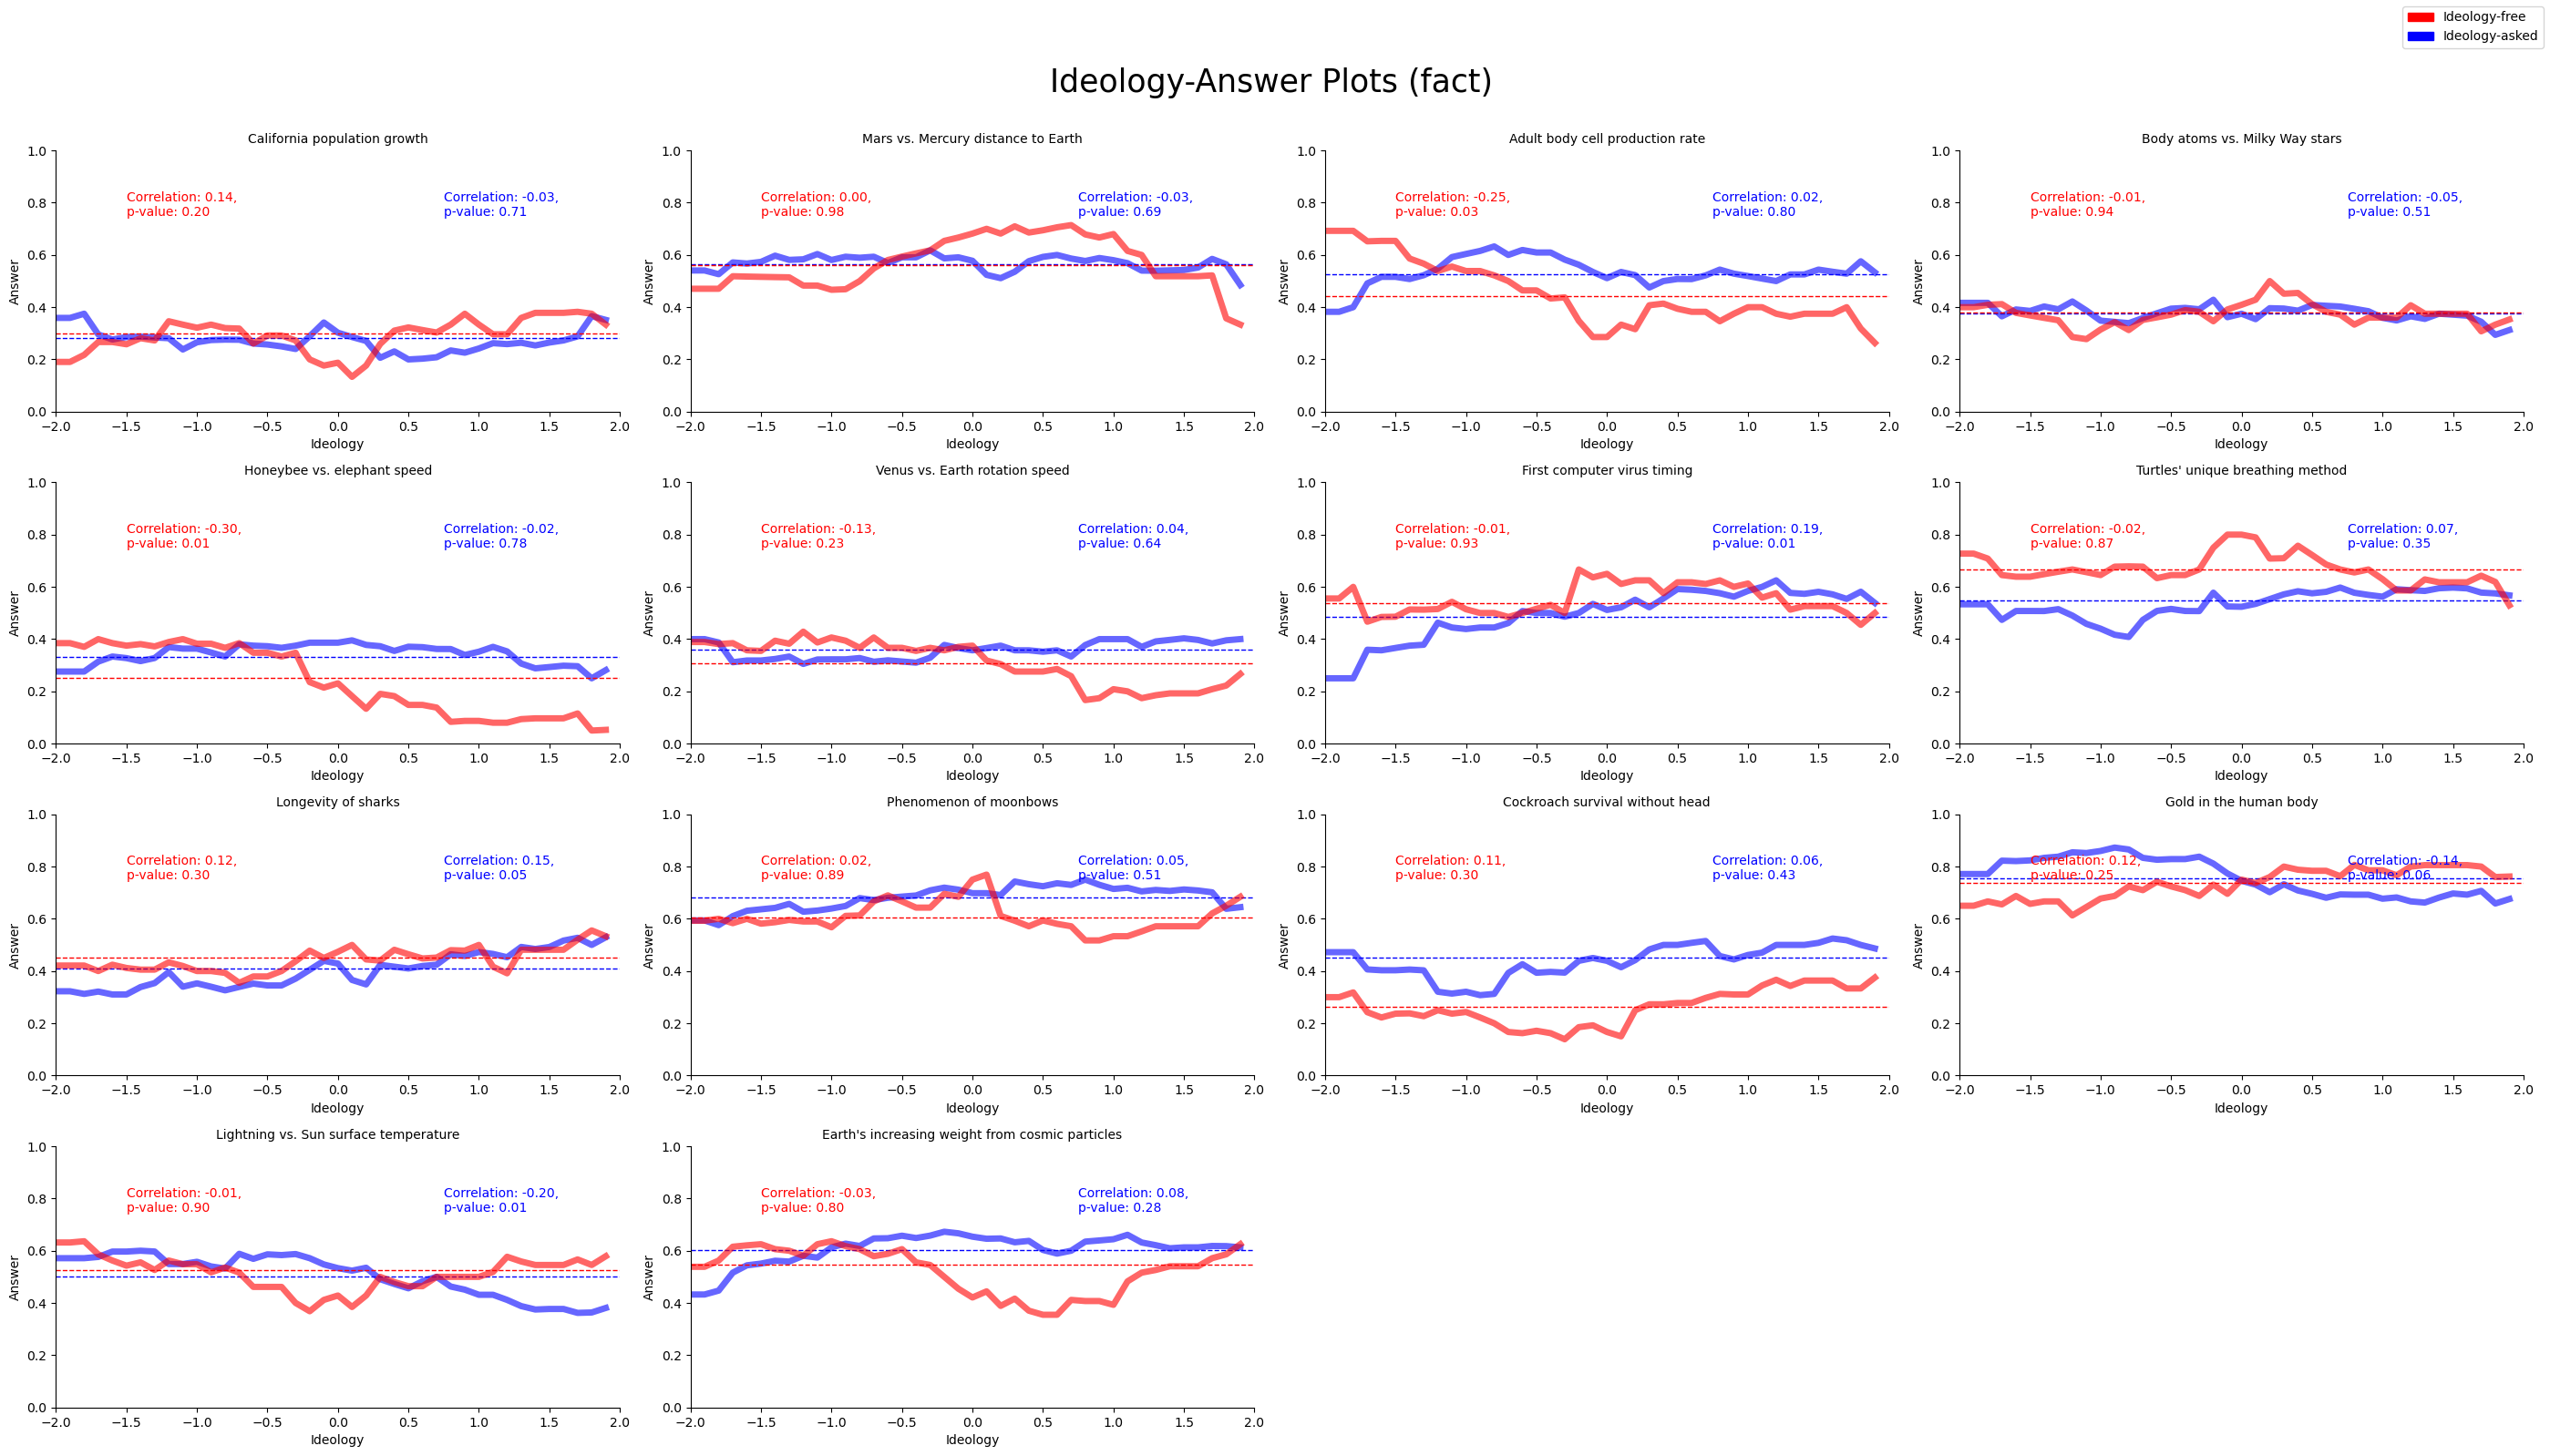

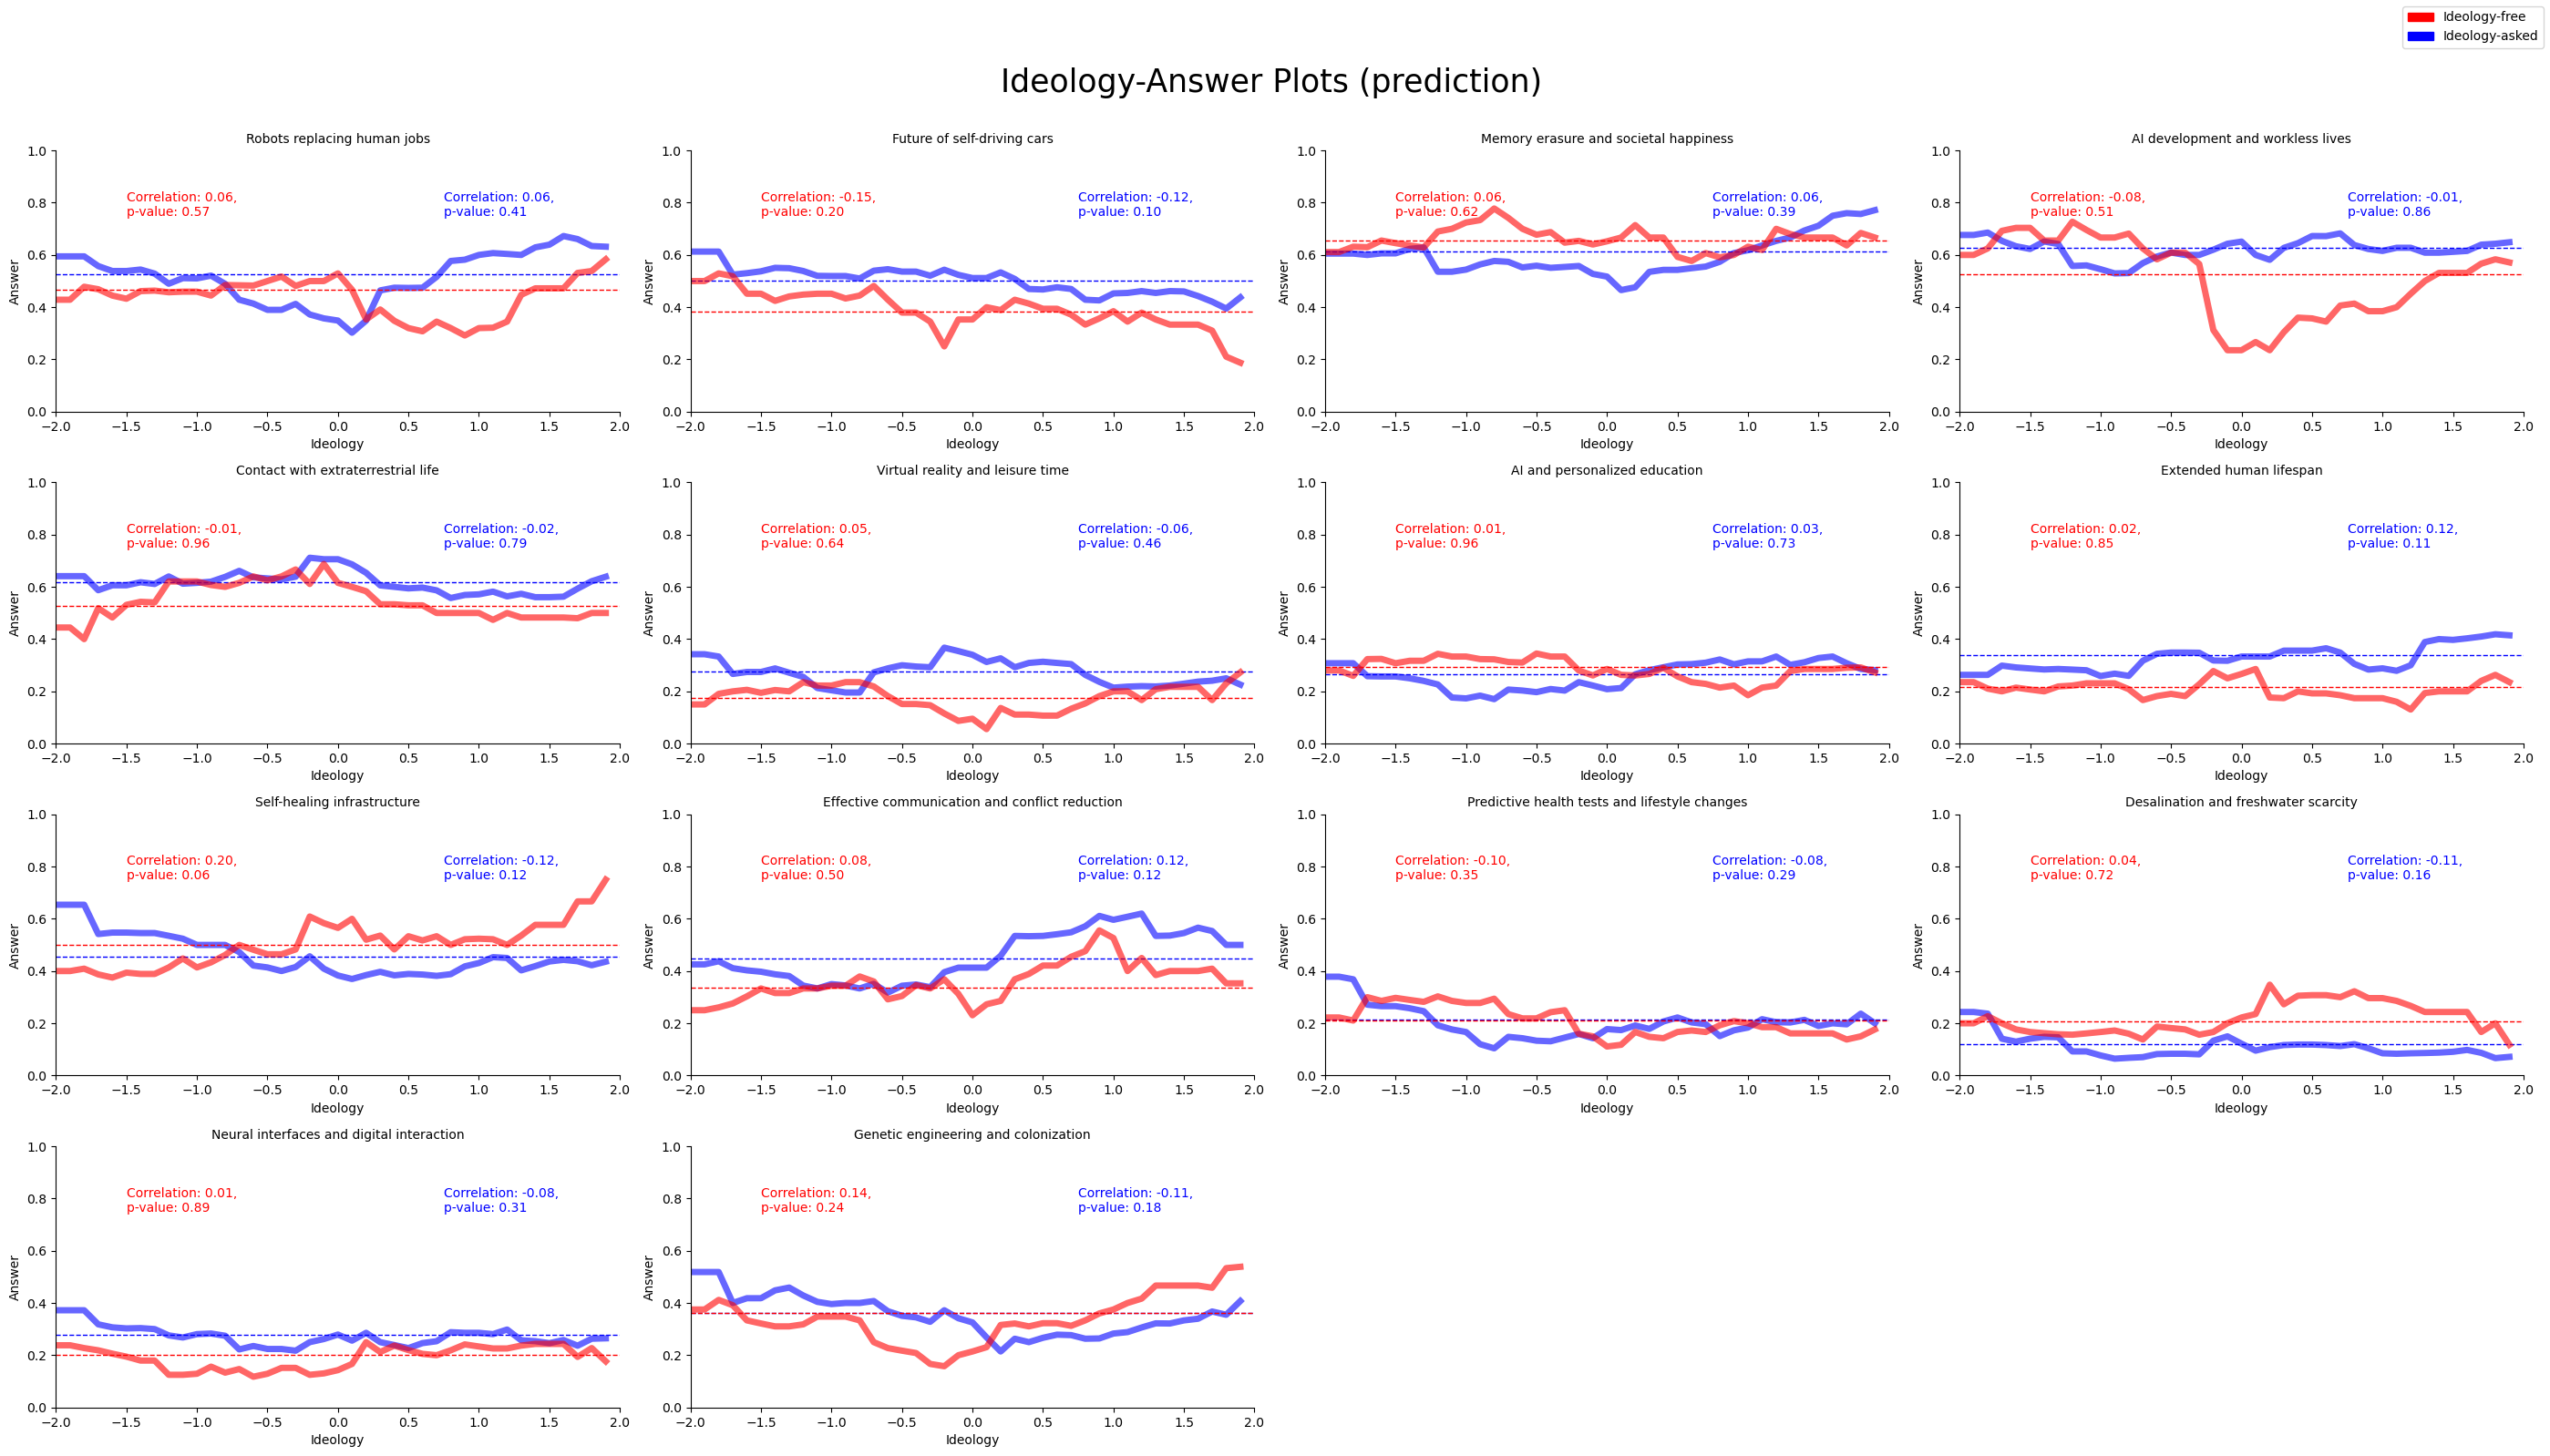

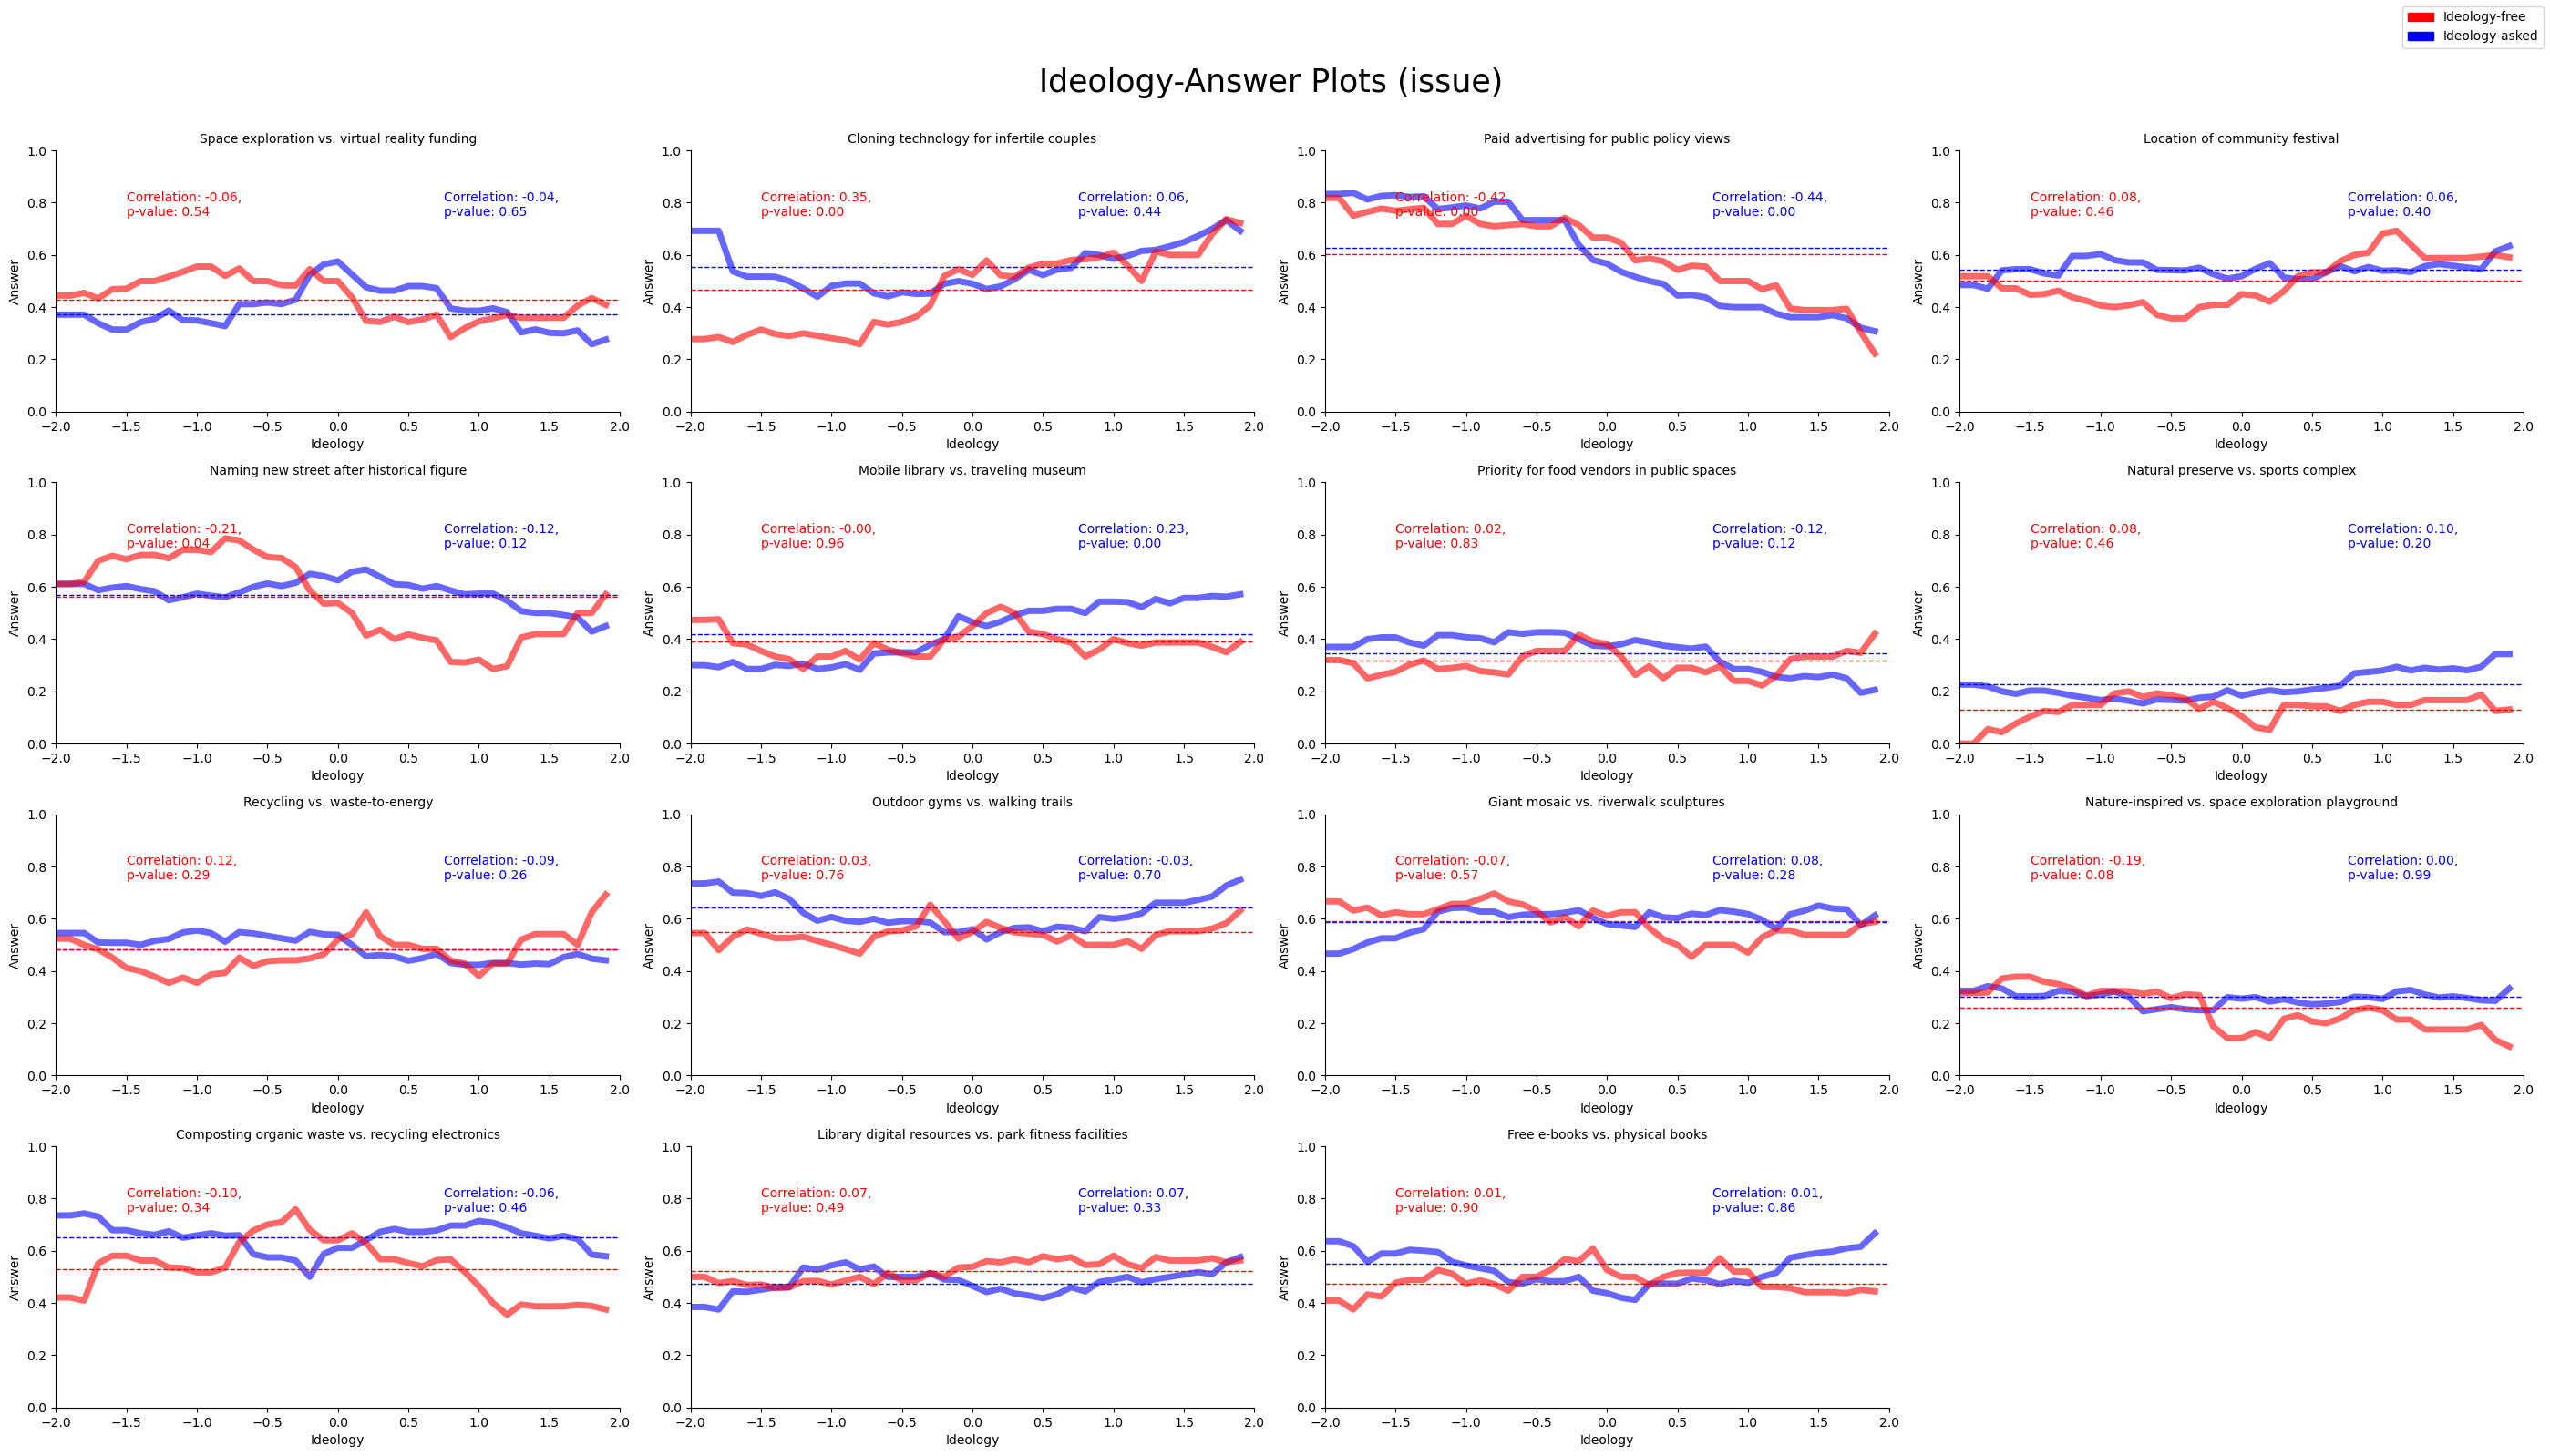

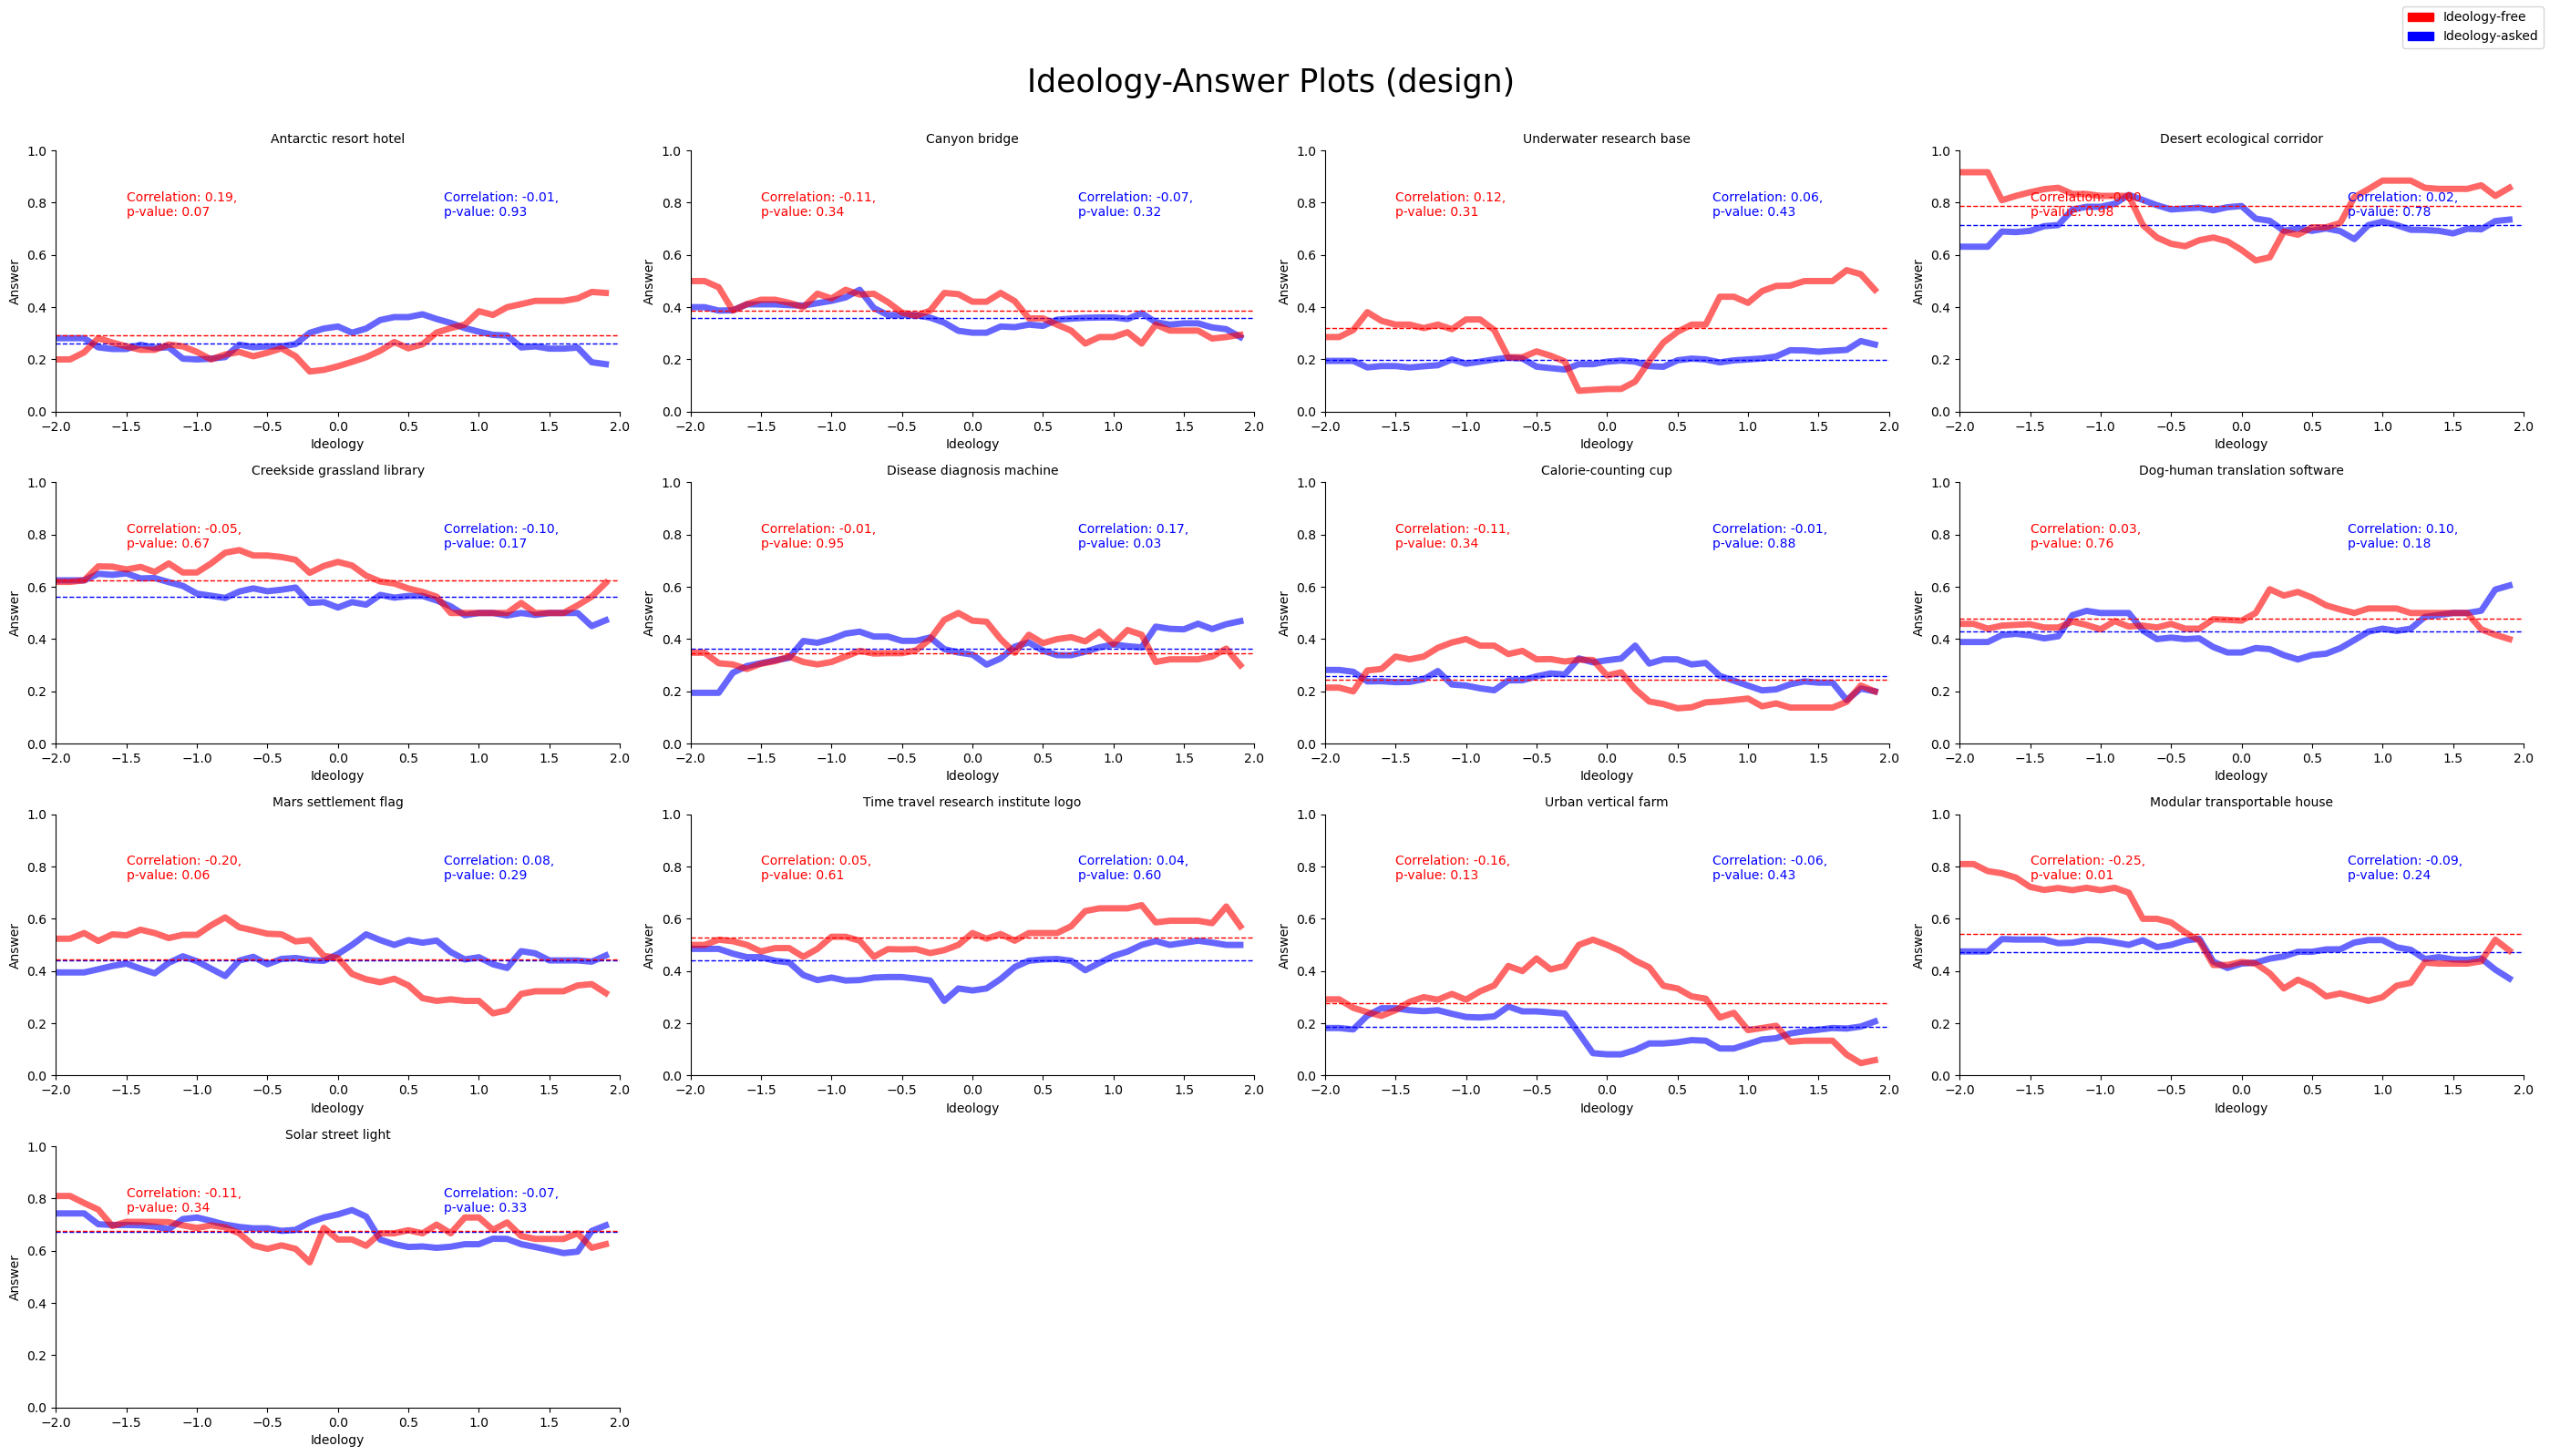

In [47]:
import textwrap
import matplotlib.patches as mpatches

for question_type in phase_2_statements.keys():
    fig, axes = plt.subplots(4, 4, figsize=(28, 16))
    fig.suptitle(f"\nIdeology-Answer Plots ({question_type})\n", fontsize=25)
    for index in range(16):
        ax = axes[index // 4][index % 4]
        if index < len(phase_2_statements[question_type]):
            question_info = phase_2_statements[question_type][index]
            ax.set(
                ylim=(0, 1),
                xlim=(-2, 2),
                xlabel="Ideology",
                ylabel="Answer",
            )
            title = textwrap.fill(question_info["summary"], 70)
            ax.set_title(title, fontsize=10)
            color_map = {0: "blue", 1: "red"}
            text_x = {0: 0.75, 1: -1.5}
            for bot_detected in [0, 1]:
                x = df_each.loc[bot_detected, question_type, index]["ideology"]
                y = df_each.loc[bot_detected, question_type, index]["answer"]
                answer_avg = y.mean()
                ax.axhline(answer_avg, linestyle="--", linewidth=1, color=color_map[bot_detected], lw=1)
                correlation = pearsonr(x, y)[0], pearsonr(x, y)[1]
                ax.text(text_x[bot_detected], 0.75, f"Correlation: {correlation[0]:.2f}, \np-value: {correlation[1]:.2f}", fontsize=10, color=color_map[bot_detected])
                average, low, high = sliding_average(x, y)
                ax.plot(average.index, average.values, lw=5, alpha=0.6, color=color_map[bot_detected])
        else:
            ax.axis("off")
    red_patch = mpatches.Patch(color='red', label='Ideology-free')
    blue_patch = mpatches.Patch(color='blue', label='Ideology-asked')
    fig.legend(handles=[red_patch, blue_patch])
    savefig(fig, f"visualization/{get_datetime_str()}-pilot_2-{question_type}.jpg", dpi=1000)